In [1]:
#import libraries and magic words
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
#import aws libraries
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

Load the data from S3 bucket
-----

In [3]:
#define aws attributes
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()

s3_client = boto3.client('s3')

prefix = 'capstone-project'

bucket_name = 'sagemaker-us-east-1-128100779949'

In [4]:
#list the objects in the bucket
obj_list = s3_client.list_objects(Bucket=bucket_name)

files = []

for content in obj_list['Contents']:
    files.append(content['Key'])
    
display(files)

['capstone-project/',
 'capstone-project/data/',
 'capstone-project/data/kaggle_lnr.csv',
 'capstone-project/data/mailout_test_scaled.csv',
 'capstone-project/data/mailout_train_scaled.csv']

In [5]:
#convert the objects into dataframes
data_list = ['capstone-project/data/mailout_train_scaled.csv', 'capstone-project/data/mailout_test_scaled.csv', 'capstone-project/data/kaggle_lnr.csv']

df_list = []

for file_name in data_list:
    data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)
    data_body = data_object['Body'].read()
    data_stream = io.BytesIO(data_body)
    df_list.append(pd.read_csv(data_stream, index_col=0))
    
mailout_train_scaled = df_list[0]
mailout_test_scaled = df_list[1]
kaggle_lnr = df_list[2]

In [6]:
#explore the data
display(mailout_train_scaled.head(), mailout_train_scaled.info(), mailout_train_scaled.describe())
display(mailout_test_scaled.head(), mailout_test_scaled.info(), mailout_test_scaled.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35100 entries, 0 to 35099
Columns: 359 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(359)
memory usage: 96.4 MB


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.75,0.000,0.380952,0.32,0.034247,0.0,0.0,0.041667,0.035230,0.0,...,0.454545,0.153846,0.090909,1.000000,1.0,0.375,0.4,0.0,1.0,0.375
1,0.50,0.375,0.619048,0.52,0.002283,0.0,0.0,0.083333,0.002710,0.0,...,0.090909,0.153846,0.090909,0.666667,1.0,0.875,0.0,0.0,1.0,0.250
2,0.50,0.000,0.428571,0.28,0.000000,0.0,0.0,0.000000,0.002710,0.0,...,0.545455,0.307692,0.181818,0.000000,1.0,0.250,0.4,0.0,0.0,0.375
3,0.75,0.000,0.285714,0.24,0.009132,0.0,0.0,0.083333,0.010840,0.0,...,0.727273,0.846154,1.000000,1.000000,1.0,0.125,0.4,0.0,1.0,0.375
4,0.75,0.000,0.428571,0.36,0.121005,0.0,0.0,0.041667,0.119241,0.0,...,0.181818,0.153846,0.090909,1.000000,1.0,0.375,0.4,0.0,0.0,0.250


None

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,...,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000,35100.000000
mean,0.458697,0.065050,0.490532,0.381556,0.015311,0.002444,0.014872,0.084171,0.017013,0.004772,...,0.389358,0.343425,0.280593,0.706054,0.967429,0.507553,0.350199,0.012450,0.579003,0.315477
std,0.337360,0.216828,0.289558,0.185667,0.034623,0.018902,0.066051,0.056698,0.038857,0.052012,...,0.288794,0.253785,0.230468,0.352106,0.123693,0.255695,0.244286,0.110885,0.493726,0.101453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.380952,0.320000,0.002283,0.000000,0.000000,0.041667,0.002710,0.000000,...,0.090909,0.153846,0.090909,0.333333,1.000000,0.375000,0.200000,0.000000,0.000000,0.250000
50%,0.500000,0.000000,0.476190,0.400000,0.004566,0.000000,0.000000,0.083333,0.005420,0.000000,...,0.272727,0.307692,0.181818,1.000000,1.000000,0.375000,0.400000,0.000000,1.000000,0.375000
75%,0.750000,0.000000,0.714286,0.480000,0.015982,0.000000,0.000000,0.125000,0.018970,0.000000,...,0.636364,0.538462,0.363636,1.000000,1.000000,0.875000,0.400000,0.000000,1.000000,0.375000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42833 entries, 0 to 42832
Columns: 358 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(358)
memory usage: 117.3 MB


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.75,0.111111,0.333333,0.24,0.005277,0.0,0.0,0.142857,0.005333,0.0,...,1.00,0.454545,0.461538,0.272727,1.000000,1.0,0.375,0.4,0.0,0.375
1,0.00,0.111111,0.000000,0.00,0.052770,0.0,0.0,0.071429,0.056000,0.0,...,0.25,0.454545,0.153846,0.090909,1.000000,1.0,0.625,0.4,0.0,0.375
2,0.75,1.000000,0.761905,0.44,0.005277,0.0,0.0,0.285714,0.005333,0.0,...,0.75,0.818182,0.461538,0.272727,0.333333,1.0,0.500,0.4,1.0,0.375
3,0.00,0.777778,0.000000,0.00,0.002639,0.0,0.0,0.000000,0.002667,0.0,...,0.50,0.545455,0.461538,0.272727,0.000000,1.0,0.250,0.4,1.0,0.375
4,0.50,0.111111,1.000000,0.52,0.002639,0.0,0.0,0.285714,0.002667,0.0,...,0.25,0.181818,0.307692,0.272727,0.500000,1.0,0.875,0.6,1.0,0.375


None

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,...,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000
mean,0.384359,0.141622,0.409174,0.318438,0.014639,0.001849,0.010879,0.121288,0.013878,0.003058,...,0.478130,0.326085,0.287431,0.233860,0.580187,0.813752,0.420038,0.360007,0.595475,0.277561
std,0.353694,0.187398,0.321122,0.221231,0.036146,0.015298,0.052576,0.103522,0.034566,0.034521,...,0.348974,0.300825,0.263539,0.233140,0.417347,0.370896,0.303980,0.224125,0.490806,0.133719
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.111111,0.000000,0.000000,0.002639,0.000000,0.000000,0.071429,0.002667,0.000000,...,0.250000,0.090909,0.076923,0.090909,0.166667,1.000000,0.250000,0.400000,0.000000,0.250000
50%,0.500000,0.111111,0.428571,0.360000,0.002639,0.000000,0.000000,0.071429,0.002667,0.000000,...,0.500000,0.181818,0.230769,0.181818,0.666667,1.000000,0.375000,0.400000,1.000000,0.375000
75%,0.750000,0.111111,0.619048,0.480000,0.013193,0.000000,0.000000,0.142857,0.013333,0.000000,...,0.750000,0.545455,0.461538,0.363636,1.000000,1.000000,0.625000,0.400000,1.000000,0.375000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Prepare training and validation data
-----

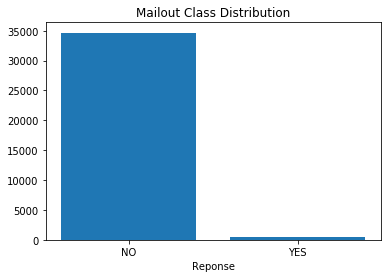

In [7]:
#check if the data is imbalance
imbalance = mailout_train_scaled['RESPONSE'].value_counts()

plt.bar(height=imbalance.values, x=['NO', 'YES'])
plt.title('Mailout Class Distribution')
plt.xlabel('Reponse')
plt.savefig('Class_imbalance')
plt.show()

In [8]:
#seperate the data
mailout_train_response = mailout_train_scaled[mailout_train_scaled['RESPONSE'] == 1]
mailout_train_others = mailout_train_scaled.drop(mailout_train_scaled.index[mailout_train_scaled['RESPONSE'] == 1])

In [9]:
#seperate the label
X_response = mailout_train_response.drop(['RESPONSE'], axis=1)
Y_response = mailout_train_response['RESPONSE']

In [10]:
#seperate the label
X_others = mailout_train_others.drop(['RESPONSE'], axis=1)
Y_others = mailout_train_others['RESPONSE']

In [11]:
#split the data to training and validation group
X_train_response, X_val_response, Y_train_response, Y_val_response = train_test_split(X_response, Y_response, test_size=0.3)
X_train_others, X_val_others, Y_train_others, Y_val_others = train_test_split(X_others, Y_others, test_size=0.3)

In [12]:
#concat the label back
X_train = pd.concat([X_train_response, X_train_others])
Y_train = pd.concat([Y_train_response, Y_train_others])
X_val = pd.concat([X_val_response, X_val_others])
Y_val = pd.concat([Y_val_response, Y_val_others])

In [13]:
#shuffle the data
X_train, Y_train = shuffle(X_train, Y_train, random_state=11)
X_val, Y_val = shuffle(X_val, Y_val, random_state=11)

In [ ]:
#save the data in local directory
source_dir = 'data'

pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(source_dir, 'train.csv'), header=False, index=False)
pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(source_dir, 'validation.csv'), header=False, index=False)

In [ ]:
#upload the data to s3 bucket
train_location = sagemaker_session.upload_data(os.path.join(source_dir, 'train.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(source_dir, 'validation.csv'), key_prefix=prefix)

Linear Learner Model
-----------

In [16]:
# #build the linear learner model
# container = get_image_uri(sagemaker_session.boto_region_name, 'linear-learner')

# output_path = 's3://{}/{}/'.format(bucket_name, prefix)

# Linear = sagemaker.estimator.Estimator(container,
#                                        role,
#                                        train_instance_count=1,
#                                        train_instance_type='ml.p2.xlarge',
#                                        output_path=output_path,
#                                        sagemaker_session=sagemaker_session)

# Linear.set_hyperparameters(feature_dim=358,
#                            predictor_type='binary_classifier',
#                            binary_classifier_model_selection_criteria='f_beta',
#                            learning_rate=0.0001,
#                            use_bias=True,
#                            l1=0,
#                            positive_example_weight_mult='balanced',
#                            epochs=100)

In [17]:
# #build a hyperparameter tuner
# Linear_hyperparameter_tuner = HyperparameterTuner(estimator=Linear,
#                                                   objective_metric_name='validation:binary_f_beta',
#                                                   objective_type='Maximize',
#                                                   max_jobs=30,
#                                                   max_parallel_jobs=3,
#                                                   hyperparameter_ranges={
#                                                     'learning_rate': ContinuousParameter(0.0001, 0.01),
#                                                     'l1': ContinuousParameter(0.0001, 0.01),
#                                                    })

In [18]:
#fit the training data in the estimator
# s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
# s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='text/csv')

# Linear_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [19]:
#show the progress
# Linear_hyperparameter_tuner.wait()

In [20]:
#attach the best training job back to the estimator
# Linear_attached = sagemaker.estimator.Estimator.attach(Linear_hyperparameter_tuner.best_training_job())

In [21]:
#deploy the model to create a predictor
# Linear_predictor = Linear_attached.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

In [22]:
#config the predictor
# Linear_predictor.content_type = 'text/csv'
# Linear_predictor.serializer = csv_serializer
# Linear_predictor.deserializer = json_deserializer

In [23]:
#make predictions
# Linear_prediction_batches = [Linear_predictor.predict(batch) for batch in np.array_split(mailout_test_scaled.to_numpy(), 100)]

In [24]:
#delete the endpoint
# Linear_predictor.delete_endpoint()

In [25]:
#save the result in DataFrame
# Linear_predictions = pd.DataFrame()
# for batch in Linear_prediction_batches:
#     Linear_predictions = Linear_predictions.append(pd.DataFrame(batch['predictions']))

In [26]:
#create a dataframe to submit to kaggle
# kaggle_submission = pd.concat([kaggle_lnr, Linear_predictions.reset_index()], axis=1).drop(['index', 'predicted_label'], axis=1)
# kaggle_submission = kaggle_submission.set_index(kaggle_submission['LNR']).drop(['LNR'], axis=1)
# kaggle_submission.columns = ['RESPONSE']

In [27]:
#create a csv to submit to kaggle
# kaggle_submission.to_csv('kaggle_submission.csv')

XGBoost Model
-------

In [28]:
#build the xgb model
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

output_path = 's3://{}/{}/'.format(bucket_name, prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.c4.4xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sagemaker_session)


xgb.set_hyperparameters(alpha=1,
                        max_depth=5,
                        eta=0.2,
                        gamma=3,
                        min_child_weight=5,
                        subsample=0.7,
                        objective='binary:logistic',
                        early_stopping_rounds=100,
                        num_round=4000,
                        eval_metric='auc',
                        scale_pos_weight=80)

	get_image_uri(region, 'xgboost', '0.90-1').


In [29]:
#build a hyperparameter tuner
xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb,
                                               objective_metric_name='validation:auc',
                                               objective_type='Maximize',
                                               max_jobs=20,
                                               max_parallel_jobs=3,
                                               hyperparameter_ranges={
                                                'alpha': ContinuousParameter(1, 100),
                                                'max_depth': IntegerParameter(1, 9),
                                                'eta': ContinuousParameter(0.1, 0.5),
                                                'gamma': ContinuousParameter(1, 4),
                                                'min_child_weight': ContinuousParameter(2, 100),
                                                'subsample': ContinuousParameter(0.6, 0.9),
                                                'lambda': ContinuousParameter(2, 500)
                                                })

In [30]:
#fit the training data in the estimator
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='text/csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [31]:
#show the progress
xgb_hyperparameter_tuner.wait()

...................................................................................................................................................................................................................................................!


In [32]:
#attach the best training job back to the estimator
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2020-02-09 14:56:40 Starting - Preparing the instances for training
2020-02-09 14:56:40 Downloading - Downloading input data
2020-02-09 14:56:40 Training - Training image download completed. Training in progress.
2020-02-09 14:56:40 Uploading - Uploading generated training model
2020-02-09 14:56:40 Completed - Training job completedArguments: train
[2020-02-09:14:56:15:INFO] Running standalone xgboost training.
[2020-02-09:14:56:15:INFO] Setting up HPO optimized metric to be : auc
[2020-02-09:14:56:15:INFO] File size need to be processed in the node: 126.15mb. Available memory size in the node: 22401.0mb
[2020-02-09:14:56:15:INFO] Determined delimiter of CSV input is ','
[14:56:15] S3DistributionType set as FullyReplicated
[14:56:15] 24569x358 matrix with 8795702 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-02-09:14:56:15:INFO] Determined delimiter of CSV input is ','
[14:56:15] S3DistributionType set as FullyReplicated
[14:56:15] 10531x358 m

In [33]:
#deploy the model to create a predictor
xgb_predictor = xgb_attached.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

-----------------!

In [34]:
#config the predictor
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [35]:
#make predictions
xgb_prediction_batches = [xgb_predictor.predict(batch) for batch in np.array_split(mailout_test_scaled.to_numpy(), 100)]

In [36]:
#delete the endpoint
xgb_predictor.delete_endpoint()

In [37]:
#save the result in DataFrame
xgb_predictions = pd.DataFrame()
for batch in xgb_prediction_batches:
    xgb_predictions = xgb_predictions.append(pd.DataFrame(np.fromstring(batch, sep=',')))

In [38]:
#create a dataframe to submit to kaggle
kaggle_submission = pd.concat([kaggle_lnr, xgb_predictions.reset_index()], axis=1).drop(['index'], axis=1)
kaggle_submission = kaggle_submission.set_index(kaggle_submission['LNR']).drop(['LNR'], axis=1)
kaggle_submission.columns = ['RESPONSE']

In [39]:
#create a csv to submit to kaggle
kaggle_submission.to_csv('kaggle_submission.csv')